In [2]:
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("Coded_Segments.csv")
print(df.head())

               Dokumentname         Code  Anfang  Ende  \
0  reflection_assignment_P1      Level 1       1     1   
1  reflection_assignment_P1      Level 1       1     1   
2  reflection_assignment_P1      Level 1       1     1   
3  reflection_assignment_P1  Level 2 (a)       1     1   
4  reflection_assignment_P1  Level 2 (a)       1     1   

                                             Segment  
0  I am a newbie in data science (DS). On the one...  
1  However, the handling of data in basic cogniti...  
2  The HCDS course was largely aimed at a critica...  
3  Among these topics, some messages particularly...  
4  First of all, I became aware of the importance...  


In [4]:
df['Code'].value_counts()

Code
Level 3        90
Level 1        69
Level 2 (b)    41
Level 2 (a)    31
Level 4         6
Name: count, dtype: int64

(array([69.,  0., 31.,  0.,  0., 41.,  0., 90.,  0.,  6.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

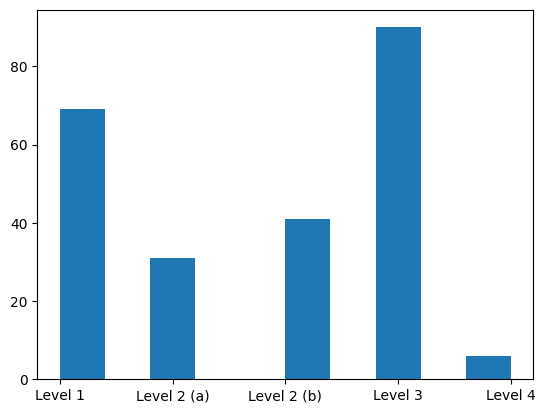

In [5]:
plt.hist(sorted(df['Code']))

In [6]:
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    ordinal_mapping = ['Level 1', 'Level 2 (a)', 'Level 2 (b)', 'Level 3', 'Level 4']  # Ensure correct order
    oe = OrdinalEncoder(categories=[ordinal_mapping]) # Define order
    df['class'] = oe.fit_transform(df[['Code']]).astype(int).flatten()

    # handle imbalanced dataset
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(df[['Segment']], df['class'])
    df_resampled = pd.DataFrame({'Segment': X_resampled['Segment'], 'class': y_resampled})

    print(f"Original dataset shape: {df.shape}")
    print(f"Resampled dataset shape: {df_resampled.shape}")

    return df_resampled, oe

In [7]:
df_resampled, ordinal_encoder = preprocess_data(df)
print(df_resampled)

Original dataset shape: (237, 6)
Resampled dataset shape: (450, 2)
                                               Segment  class
0    I am a newbie in data science (DS). On the one...      0
1    However, the handling of data in basic cogniti...      0
2    The HCDS course was largely aimed at a critica...      0
3    Among these topics, some messages particularly...      1
4    First of all, I became aware of the importance...      1
..                                                 ...    ...
445  The first concern, to begin  with, is to check...      4
446  The first concern, to begin  with, is to check...      4
447  Social nuances have shown how important it is ...      4
448  It also made me realise the high personal resp...      4
449  As an when my experience grew, I started to un...      4

[450 rows x 2 columns]


In [8]:
df_resampled['class'].value_counts()

class
0    90
1    90
4    90
2    90
3    90
Name: count, dtype: int64

(array([90.,  0., 90.,  0.,  0., 90.,  0., 90.,  0., 90.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

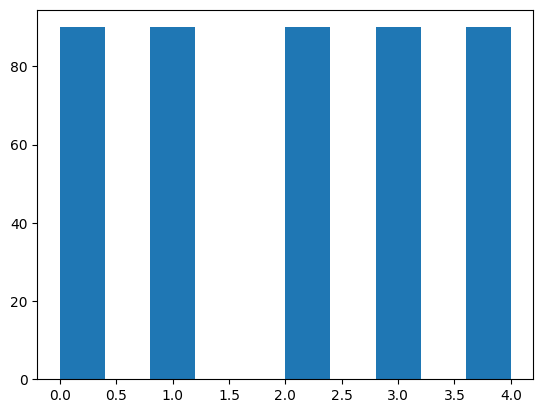

In [9]:
plt.hist(sorted(df_resampled['class']))

In [10]:
# Preprocessing
# Split into training, validation and test sets
train_df, temp_df = train_test_split(df_resampled, test_size=0.3, stratify=df_resampled['class'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['class'], random_state=42)

# Extract text and labels
X_train, y_train = train_df['Segment'], train_df['class']
X_val, y_val = val_df['Segment'], val_df['class']
X_test, y_test = test_df['Segment'], test_df['class']

# Convert text to numerical features using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

Validation Set Results:
Accuracy: 0.69
Cohen's Kappa: 0.61
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.54      0.70        13
           1       0.62      0.93      0.74        14
           2       0.48      0.92      0.63        13
           3       0.00      0.00      0.00        13
           4       1.00      1.00      1.00        14

    accuracy                           0.69        67
   macro avg       0.62      0.68      0.61        67
weighted avg       0.63      0.69      0.62        67



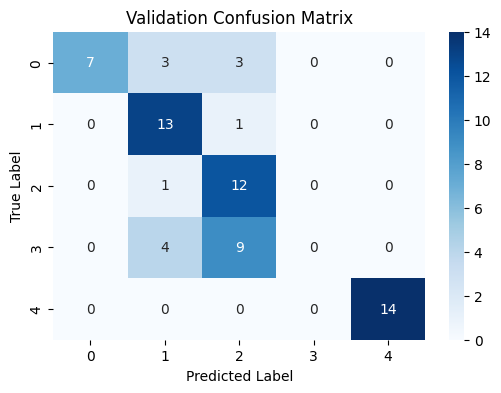


Test Set Results:
Accuracy: 0.71
Cohen's Kappa: 0.63
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.57      0.73        14
           1       0.63      0.92      0.75        13
           2       0.52      1.00      0.68        14
           3       1.00      0.07      0.13        14
           4       1.00      1.00      1.00        13

    accuracy                           0.71        68
   macro avg       0.83      0.71      0.66        68
weighted avg       0.83      0.71      0.65        68



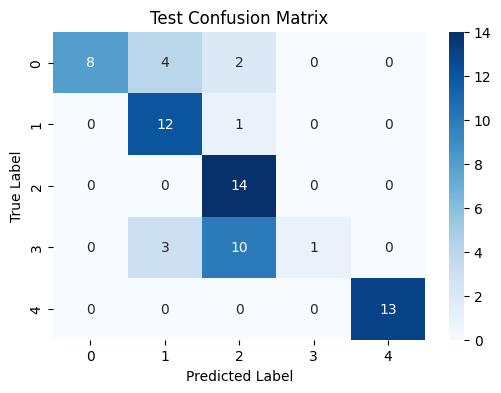

In [11]:
# Get unique ordinal levels
unique_classes = sorted(y_train.unique())
thresholds = unique_classes[:-1]  # Exclude last class (no threshold needed)
num_classes = len(unique_classes)
num_classes

# Train multiple SVM models (Pairwise constraints)
svm_models = []
for threshold in thresholds:
    binary_labels = (y_train > threshold).astype(int)  # "Is class >= k?"
    svm = SVC(kernel='linear', probability=True, random_state=42)
    svm.fit(X_train_tfidf, binary_labels)
    svm_models.append(svm)

# Prediction function
def ordinal_svm_predict(models, X):
    prob_matrix = np.zeros((X.shape[0], len(models)))
    
    for i, model in enumerate(models):
        prob_matrix[:, i] = model.predict_proba(X)[:, 1]  # Prob of class ≥ k
    
    predictions = prob_matrix.sum(axis=1)  # Count how many thresholds are exceeded
    return np.clip(predictions.round().astype(int), 0, num_classes - 1)  # Ensure within valid range

# Predictions
pcsvm_y_val_pred = ordinal_svm_predict(svm_models, X_val_tfidf)
pcsvm_y_test_pred = ordinal_svm_predict(svm_models, X_test_tfidf)

# Evaludation metrics for validation set
pcsvm_val_accuracy = accuracy_score(y_val, pcsvm_y_val_pred)
pcsvm_val_class_report = classification_report(y_val, pcsvm_y_val_pred, zero_division=0)
pcsvm_val_cohen_kappa = cohen_kappa_score(y_val, pcsvm_y_val_pred)
pcsvm_val_cm = confusion_matrix(y_val, pcsvm_y_val_pred)

# Evaludation metrics for test set
pcsvm_test_accuracy = accuracy_score(y_test, pcsvm_y_test_pred)
pcsvm_test_class_report = classification_report(y_test, pcsvm_y_test_pred, zero_division=0)
pcsvm_test_cohen_kappa = cohen_kappa_score(y_test, pcsvm_y_test_pred)
pcsvm_test_cm = confusion_matrix(y_test, pcsvm_y_test_pred)

# Print results
print("Validation Set Results:")
print(f"Accuracy: {pcsvm_val_accuracy:.2f}")
print(f"Cohen's Kappa: {pcsvm_val_cohen_kappa:.2f}")
print("Classification Report:")
print(pcsvm_val_class_report)
plt.figure(figsize=(6,4))
sns.heatmap(pcsvm_val_cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y_val)), yticklabels=sorted(set(y_val)))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Validation Confusion Matrix")
plt.show()

print("\nTest Set Results:")
print(f"Accuracy: {pcsvm_test_accuracy:.2f}")
print(f"Cohen's Kappa: {pcsvm_test_cohen_kappa:.2f}")
print("Classification Report:")
print(pcsvm_test_class_report)
plt.figure(figsize=(6,4))
sns.heatmap(pcsvm_test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Test Confusion Matrix")
plt.show()

In [13]:
# Get feature names
feature_names = vectorizer.get_feature_names_out()
n_features = len(feature_names)

# Collect model coefficients from each binary SVM
model_coefs = [model.coef_.toarray().flatten() for model in svm_models]  # shape (n_thresholds, n_features)

# For each class, compute average TF-IDF and rank important features
for class_label in sorted(y_train.unique()):
    print(f"\nTop words for class {class_label}:")

    # Get average TF-IDF for documents of this class
    class_docs = X_train_tfidf[np.array(y_train) == class_label]
    avg_tfidf = class_docs.mean(axis=0).A1  # shape (n_features,)

    # Combine all models' contributions to this class
    # Logic: for class `k`, we care about classifiers for thresholds ≤ k
    # (since we use ≥ thresholds and sum them for prediction)
    class_importance = np.zeros(n_features)
    for i, coef in enumerate(model_coefs):
        if class_label == 0:
            # Class 0 = samples where none of the thresholds are passed
            class_docs = X_train_tfidf[np.array(y_train) == class_label]
            avg_tfidf = class_docs.mean(axis=0).A1
            class_importance = avg_tfidf  # Just show top features from frequency
        if class_label > i:  # This model affects this class
            class_importance += coef * avg_tfidf

    # Top 10 feature indices for this class
    top10_idx = class_importance.argsort()[-10:][::-1]

    # Print top 10 words
    for idx in top10_idx:
        print(f"{feature_names[idx]}: {class_importance[idx]:.4f}")


Top words for class 0:
data: 0.0883
model: 0.0520
science: 0.0483
practice: 0.0306
course: 0.0275
human: 0.0259
bias: 0.0249
learning: 0.0245
principles: 0.0215
processing: 0.0209

Top words for class 1:
concepts: 0.0257
course: 0.0239
box: 0.0198
learned: 0.0189
human: 0.0172
black: 0.0142
approach: 0.0119
work: 0.0108
assignments: 0.0107
pre: 0.0093

Top words for class 2:
course: 0.0966
understand: 0.0333
new: 0.0327
learnt: 0.0313
given: 0.0289
licensing: 0.0269
score: 0.0254
study: 0.0250
fairness: 0.0247
work: 0.0228

Top words for class 3:
understand: 0.0708
new: 0.0706
decision: 0.0694
concepts: 0.0677
people: 0.0630
project: 0.0609
making: 0.0579
course: 0.0459
good: 0.0385
attributes: 0.0352

Top words for class 4:
social: 0.2171
society: 0.1861
document: 0.1714
impact: 0.1342
project: 0.1140
important: 0.1088
context: 0.0997
feel: 0.0958
things: 0.0918
responsibility: 0.0903


In [14]:
# Get feature names from the vectorizer
feature_names = np.array(vectorizer.get_feature_names_out())

# Accumulate absolute coefficients from each threshold model
coef_matrix = np.zeros((len(svm_models), len(feature_names)))

for i, model in enumerate(svm_models):
    coef_matrix[i] = np.abs(model.coef_.toarray().flatten())

# Mean importance across all models
global_feature_importance = coef_matrix.mean(axis=0)

# Get indices of top 20 important features
top20_idx = global_feature_importance.argsort()[-20:][::-1]

print("\nGlobal Top 20 Important Words:")
for idx in top20_idx:
    print(f"{feature_names[idx]}: {global_feature_importance[idx]:.4f}")


Global Top 20 Important Words:
understand: 0.7519
new: 0.6914
processing: 0.6665
feel: 0.6652
decision: 0.6560
lectures: 0.6427
society: 0.6240
document: 0.6210
people: 0.5932
making: 0.5731
social: 0.5678
science: 0.5675
different: 0.5590
personal: 0.5534
things: 0.5527
concepts: 0.5476
believe: 0.5398
project: 0.5345
ensure: 0.5297
frameworks: 0.5269
